In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import sys
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
crs = 'epsg:4326'

## 1. Data Exploration
#### 1.1 Data Download
- Download XXX from XXX. This dataset have roughly 4,056,000 observations.
- Download counties boundary from. This dataset have roughly 3,233 observations.
- Download census data from API Census Bureau. This dataset have roughly 3,220 observations.

In [3]:
#Dataframe for avg.speed
speed = gpd.read_file("C:/Users/Maca/Desktop/CAPP/Autumm 2020/Math Found ML/project/quarter2/gps_mobile_tiles.shp", crs=crs, geometry='geometry')

In [4]:
speed.head(2)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1203022122320032,28772,3165,34,8,1,"POLYGON ((24.09302 49.88402, 24.09851 49.88402..."
1,0313113213321131,20782,10180,54,2,2,"POLYGON ((-1.49963 52.95526, -1.49414 52.95526..."


In [5]:
speed.count()

quadkey       4075861
avg_d_kbps    4075861
avg_u_kbps    4075861
avg_lat_ms    4075861
tests         4075861
devices       4075861
geometry      4075861
dtype: int64

In [6]:
# zipfile of U.S. county boundaries
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
counties = gpd.read_file(county_url).to_crs(4326)
#Drop unecessary columns
counties = counties.drop(columns=['COUNTYFP','COUNTYNS', 'LSAD','CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 
                'ALAND','AWATER'])

In [7]:
counties.head(2)

,STATEFP,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry
0,31,31039,Cuming,Cuming County,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,53069,Wahkiakum,Wahkiakum County,+46.2946377,-123.4244583,"POLYGON ((-123.43640 46.23819, -123.44759 46.2..."


In [9]:
counties.count()

STATEFP     3233
GEOID       3233
NAME        3233
NAMELSAD    3233
INTPTLAT    3233
INTPTLON    3233
geometry    3233
dtype: int64

#### 1.2 Join Speed to counties
Get the speed for each county. We use how = "left" because we want to include all counties with or without speed measures.

In [11]:
#Merge Speed data with county boundaries
scounty_speed = gpd.sjoin(counties, speed, how="left", op='intersects')

In [12]:
# convert to Mbps for easier reading
scounty_speed['avg_d_mbps'] = scounty_speed['avg_d_kbps'] / 1000
scounty_speed['avg_u_mbps'] = scounty_speed['avg_u_kbps'] / 1000
scounty_speed.describe()

,index_right,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,avg_d_mbps,avg_u_mbps
count,6.395770e+05,6.395770e+05,639577.000000,639577.000000,639577.000000,639577.000000,639577.000000,639577.000000
mean,2.178982e+06,4.372371e+04,9749.917603,47.212728,4.000679,1.784206,43.723711,9.749918
std,1.139862e+06,5.889829e+04,10377.307890,55.167475,15.817709,1.867829,58.898285,10.377308
min,4.000000e+00,1.000000e+00,1.000000,0.000000,1.000000,1.000000,0.001000,0.001000
25%,1.226536e+06,1.157800e+04,2175.000000,26.000000,1.000000,1.000000,11.578000,2.175000
50%,2.233351e+06,2.984700e+04,6217.000000,34.000000,2.000000,1.000000,29.847000,6.217000
75%,3.158072e+06,5.915500e+04,14014.000000,49.000000,3.000000,2.000000,59.155000,14.014000
max,4.075856e+06,2.060968e+06,203317.000000,3106.000000,3538.000000,85.000000,2060.968000,203.317000


In [13]:
#Number of counties with speed data available
scounty_speed.count()

STATEFP        639592
GEOID          639592
NAME           639592
NAMELSAD       639592
INTPTLAT       639592
INTPTLON       639592
geometry       639592
index_right    639577
quadkey        639577
avg_d_kbps     639577
avg_u_kbps     639577
avg_lat_ms     639577
tests          639577
devices        639577
avg_d_mbps     639577
avg_u_mbps     639577
dtype: int64

In [14]:
scounty_speed.columns

Index(['STATEFP', 'GEOID', 'NAME', 'NAMELSAD', 'INTPTLAT', 'INTPTLON',
       'geometry', 'index_right', 'quadkey', 'avg_d_kbps', 'avg_u_kbps',
       'avg_lat_ms', 'tests', 'devices', 'avg_d_mbps', 'avg_u_mbps'],
      dtype='object')

#### 1.3 Aggregate
Aggregate the test by county, giving them weights based on the number of test performed.

In [16]:
#Aggregate the download speed by the number of test on a county
county_speed = (scounty_speed.groupby(["GEOID", "NAMELSAD"]).apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])})).reset_index()
    .merge(
        scounty_speed.groupby(["GEOID", "NAMELSAD"]).agg(tests=("tests", "sum")).reset_index(),
        on=["GEOID", "NAMELSAD"]))

In [17]:
county_speed.count()

GEOID            3186
NAMELSAD         3186
avg_d_mbps_wt    3180
tests            3186
dtype: int64

In [19]:
county_speed = county_speed.loc[county_speed["tests"] >= 50]
county_speed.count()

GEOID            2548
NAMELSAD         2548
avg_d_mbps_wt    2548
tests            2548
dtype: int64

In [20]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps", "More than 200 Mbps"]

county_speed['group'] = pd.cut(
    county_speed.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200,530), 
    right=False, 
    labels = labels)

In [21]:
county_speed[county_speed['avg_d_mbps_wt']>=200].head(5)

,GEOID,NAMELSAD,avg_d_mbps_wt,tests,group
194,06075,San Francisco County,274.168599,12787.0,More than 200 Mbps
1757,34035,Somerset County,203.690810,3373.0,More than 200 Mbps
1827,36067,Onondaga County,332.196703,3400.0,More than 200 Mbps
2280,44007,Providence County,524.000467,5019.0,More than 200 Mbps


#### 1.4 Visualization of values to predict
Plot the average download speed by county, and visualize the missing values.

In [27]:
county_data = counties[['GEOID', 'geometry', 'NAME', 'STATEFP']].merge(county_speed, on='GEOID', how='left').to_crs(26916)

In [28]:
county_data.columns

Index(['GEOID', 'geometry', 'NAME', 'STATEFP', 'NAMELSAD', 'avg_d_mbps_wt',
       'tests', 'group'],
      dtype='object')

In [29]:
#We will work just with USA continental
county_data = county_data[(county_data.STATEFP != '02') & (county_data.STATEFP  != '15')
                              & (county_data.STATEFP  != '69') & (county_data.STATEFP  != '78')
                             & (county_data.STATEFP  != '66') & (county_data.STATEFP  != '60')]
county_data['STATEFP'].nunique()

50

In [30]:
county_data.count()

GEOID            3186
geometry         3186
NAME             3186
STATEFP          3186
NAMELSAD         2548
avg_d_mbps_wt    2548
tests            2548
group            2548
dtype: int64

(-3007878.1659259875, 3132367.068549183, 1893304.6912839692, 6300453.480686447)

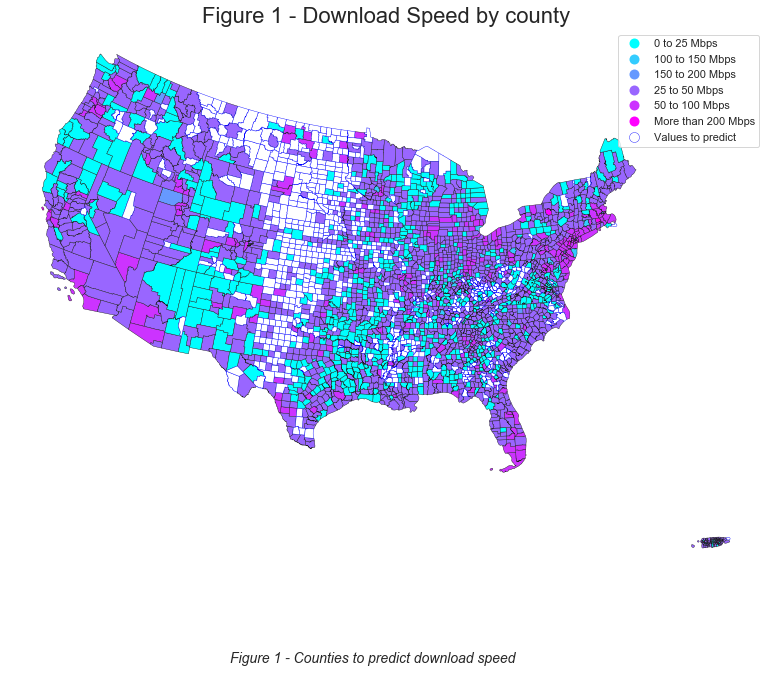

In [37]:
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
county_data.plot(column='group', ax=ax, legend=True, cmap='cool', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "white","edgecolor": "blue", "label": "Values to predict"})
# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
ax.axis("off")

#### 1.4 Get independent variables
Merge the previous dataset with cesnsus demographic data per county

In [38]:
county_data.columns

Index(['GEOID', 'geometry', 'NAME', 'STATEFP', 'NAMELSAD', 'avg_d_mbps_wt',
       'tests', 'group'],
      dtype='object')

In [39]:
#Dataframe census data
import censusdata

# Useful for finding the ACS tables you want 
# censusdata.search('acs5', 2018, 'label', 'broadband') 
# censusdata.printtable(censusdata.censustable('acs5', 2018, 'B28011'))

# Pull ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B01002_001E': 'Median Age'}

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "*"), 
                                                    ("county", "*"),]), list(census_tables.keys()))
acs_df["GEOID"] = acs_df["GEO_ID"].map(lambda x: str(x)[-5:])
acs_df = acs_df.drop(columns='GEO_ID')
acs_df = acs_df.rename(columns=census_tables)

In [43]:
# Merge ACS data with Census county boundaries
merged_gdf = (gpd.GeoDataFrame(county_data.merge(acs_df, on="GEOID", how="left"), crs=crs, geometry='geometry'))

merged_gdf.head(5)

,GEOID,geometry,NAME,STATEFP,NAMELSAD,avg_d_mbps_wt,tests,group,Race Total,White,Black,Median Income,Median Age
0,31039,"POLYGON ((-330171.352 4699069.239, -330160.610...",Cuming,31,NaN,NaN,NaN,NaN,8991,8465,7,55190.0,43.6
1,53069,"POLYGON ((-2288413.478 5806151.443, -2288581.2...",Wahkiakum,53,NaN,NaN,NaN,NaN,4189,3856,54,54085.0,54.3
2,35011,"POLYGON ((-1131778.997 3904448.706, -1131809.9...",De Baca,35,NaN,NaN,NaN,NaN,2060,1536,33,31028.0,37.0
3,31109,"POLYGON ((-336816.696 4562417.023, -336747.675...",Lancaster,31,Lancaster County,41.858402,1716.0,25 to 50 Mbps,310094,267938,12499,58009.0,33.3
4,31129,"POLYGON ((-462102.105 4499067.745, -462101.934...",Nuckolls,31,NaN,NaN,NaN,NaN,4275,4180,7,42049.0,49.3


In [45]:
merged_gdf.describe()

,avg_d_mbps_wt,tests,Race Total,White,Black,Median Income,Median Age
count,2548.000000,2548.000000,3.186000e+03,3.186000e+03,3.186000e+03,3185.000000,3186.000000
mean,34.887510,992.157378,1.017355e+05,7.418521e+04,1.294122e+04,50603.719937,41.312272
std,21.333157,3122.815462,3.273181e+05,2.021982e+05,5.541910e+04,14355.842834,5.328537
min,4.482673,50.000000,1.020000e+02,9.900000e+01,0.000000e+00,12812.000000,21.700000
25%,24.081473,140.750000,1.142075e+04,9.190750e+03,1.210000e+02,41855.000000,38.100000
50%,31.630698,285.000000,2.624250e+04,2.197250e+04,8.545000e+02,49375.000000,41.200000
75%,40.829592,749.250000,6.663700e+04,5.726625e+04,5.681250e+03,57019.000000,44.400000
max,524.000467,92244.000000,1.009805e+07,5.186859e+06,1.230494e+06,136268.000000,67.000000


In [46]:
merged_gdf.to_csv('Data_to_predict.csv')